### The layers

The layer structure of the evals is motivated by the idea that evals should be as interpretable as possible.

In this project, level 0 evals test the structure of the output and level 1 evals test the content. In theory, this could be split into more precise levels, more levels can be added, etc.

### The level 0 evals

Level 0 is fairly interpretable. It is currently set up so (1) if the JSON formatting is invalid or (2) the JSON is missing elements, the level_0_evals function will fail. The level 0 score is calculated as the percentage of attempts that pass. For example, if 8 out of 10 attempts on episode i contain a valid output structure, the score for episode i is .8.

Below, we evaluate a very simple text prompt (shown in next block) on the level_0_evals.

In [1]:
"""
    The prompt:
    response = client.beta.tools.messages.create(
        model=MODEL,
        max_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
        # system=SYSTEM_PROMPT,
        messages=[{
            "role": "user",
            "content": f"Get story arcs as a list of JSON objects containing a label (string), description (string), characters (array of strings), and themes (array of strings) from the below script:\n{script}"
        }]
    )
"""

CONTROL_EXPERIMENT_1_OUT_DIR = "./simple_prompt"
TRANSCRIPTS_DIR = "./transcripts"

import os
os.environ['ANTHROPIC_API_KEY'] = 'API_KEY_HERE'

# Commented code was used to generate the data, saved in CONTROL_EXPERIMENT_OUT_DIR for simplicity
# import anthropic
# from query import query_all
# query_all(TRANSCRIPTS_DIR, CONTROL_EXPERIMENT_OUT_DIR, anthropic.Anthropic())

# Level 0 Evals: Validate the Output Format
import re
from evals import level_0_evals

files = os.listdir(CONTROL_EXPERIMENT_1_OUT_DIR)
scores = [0.0] * 10 # score[i] = average score for episode i
episodes = [[] for _ in range(10)] # episodes[i] is a list of all valid json arcs extracted for episode i across all attempts

for file in files:
    episode = int(re.search(r'ep(\d+)', file).group(1)) # Pattern to find 'ep' followed by digits
    with open(os.path.join(CONTROL_EXPERIMENT_1_OUT_DIR, file), "r") as file:
        response = file.read()
    valid, json_arcs = level_0_evals(response)
    if valid:
        scores[episode-1] += 1
        episodes[episode-1].append((json_arcs, file.name)) # Save filename for visibility in what is happening later in the pipeline
scores = [score/10 for score in scores] # Assuming 10 attempts per episode, to generalize keep a count array

print(f"Level 0 Scores per Episode: {scores}")
print(f"Level 0 Score Total: {sum(scores)/len(scores)}")


/Users/shreyawadehra/miniforge3/envs/fathom/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shreyawadehra/miniforge3/envs/fathom/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/shreyawadehra/miniforge3/envs/fathom/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Level 0 Scores per Episode: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Level 0 Score Total: 0.0


Here, we can argue that adjusting the parsing of the LLM's JSON response would increase the level_0_evals scores. However, it seems very not scalable to adjust the parsing logic every time we adjust the prompt. Therefore, it makes more sense that we define what we expect the LLM to return once, and then make sure it always adheres to that format.

By comparison, the level_0_score for the submitted prompt is .75, indicating that 75% passed the parsing logic and is in the predefined format we expect to see.

### The level 1 evals

How It Works:

For each attempt (one llm query) on each episode transcript:
1. we generate embeddings for the input (the transcripts). [lots of embeddings, but can be stored]
2. we generate embeddings for the output (the descriptions). [not a lot of embeddings, require dynamic computation]
3. for each output embedding, we find N. N is how many input embeddings are within some threshold (set to 0.435 distance currently). [O(not a lot of embeddings)]
4. the average of Ns gives us the score for one llm query on one episode transcript

The scores for each attempt are then averaged to get the final episode score. The score for each episode is then averaged to get the final level_1_score.

Since the embeddings space is very not interpretable, I've provided a control experiment to give a preliminary indication that something like this might be of use.

To simulate a "bad" reasoning response (but still related to the storylines of the same TV show), let's calculate the score of the prompts evaluated against the wrong transcript file (i.e. arcs from episode i evaluated with all transcripts j != i)

Running the below code for various threshold levels was also the method used to tune the "threshold" parameter when finding embeddings within a certain threshold.

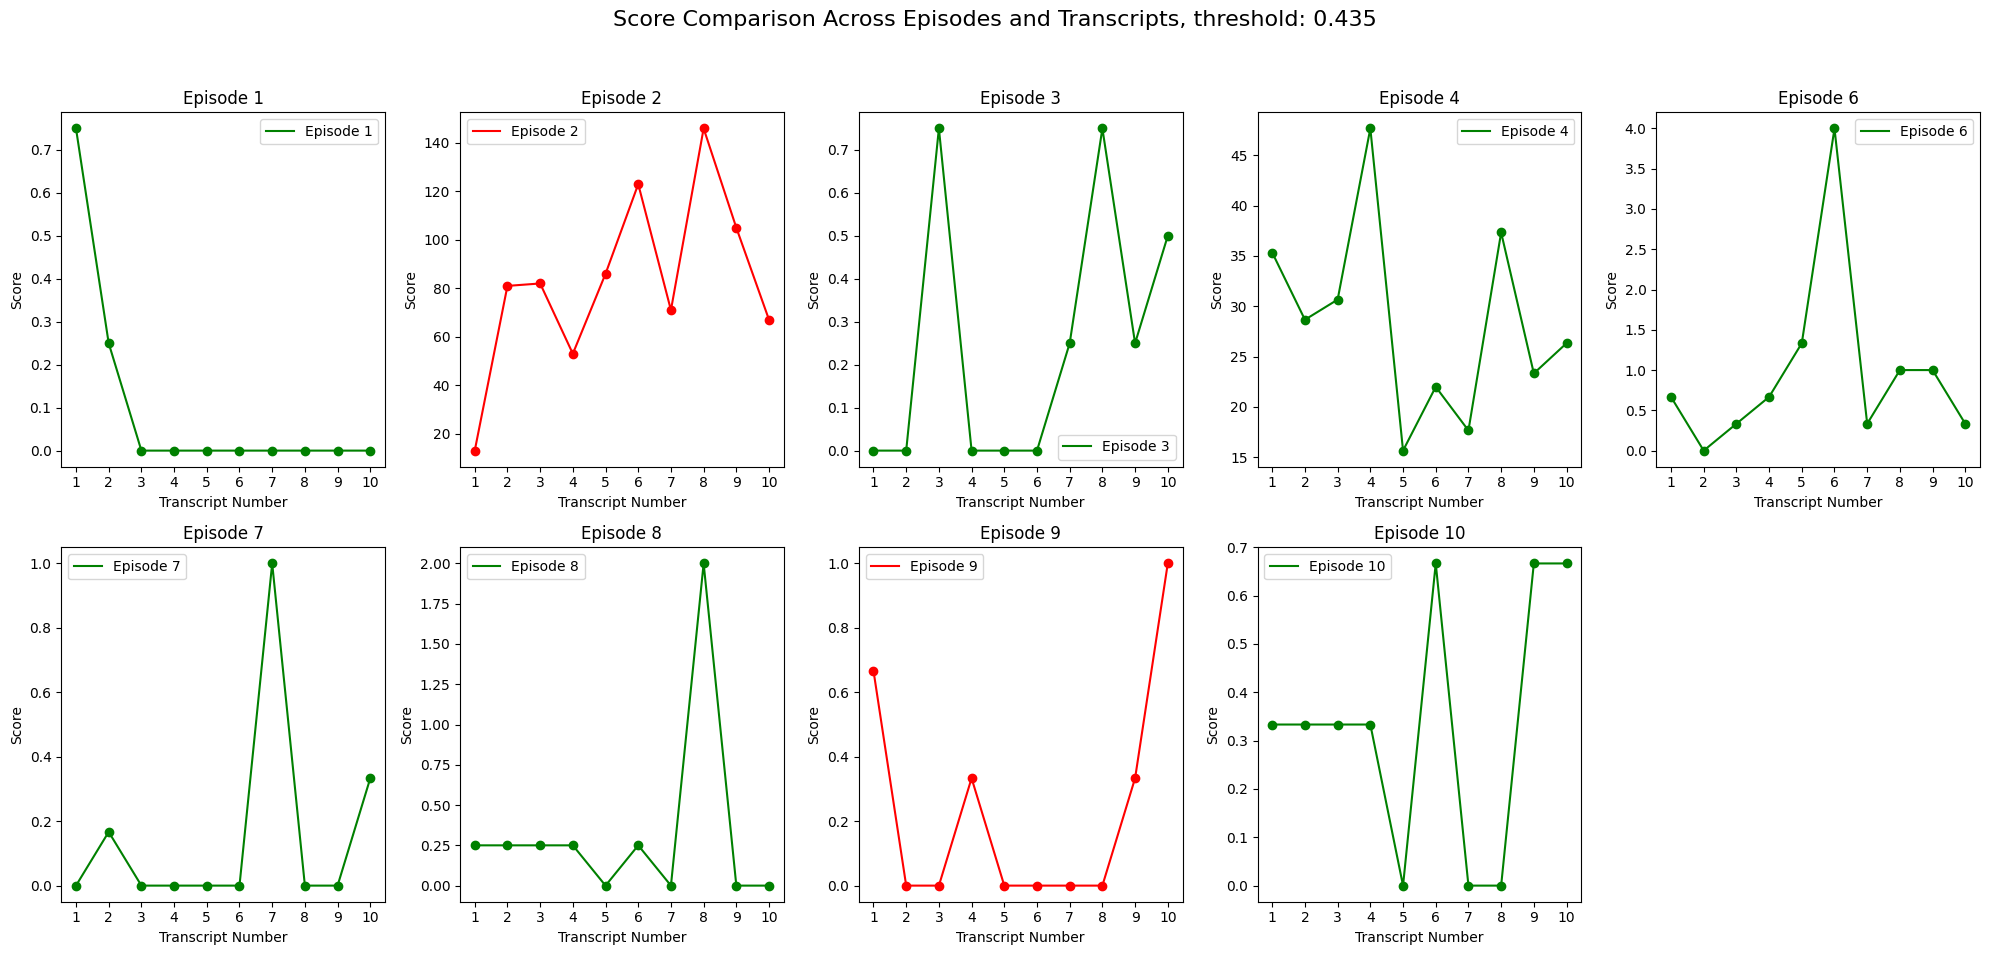

In [2]:
from evals import plot_evals_per_episode

filenames = [
    "./attempts/ep1_attempt_9.txt",
    "./attempts/ep2_attempt_9.txt",
    "./attempts/ep3_attempt_1.txt",
    "./attempts/ep4_attempt_6.txt",
    "./attempts/ep6_attempt_6.txt",
    "./attempts/ep7_attempt_8.txt",
    "./attempts/ep8_attempt_5.txt",
    "./attempts/ep9_attempt_1.txt",
    "./attempts/ep10_attempt_4.txt"
]

plot_evals_per_episode(threshold=0.435, filenames=filenames)

Generally, the outputs for episode i score high only with the transcript for episode i (green graphs). There are some cases where this doesn't happen (red graphs). This could be because the arcs for the episodes are related. Or it could be because the evaluation metric isn't good enough to capture what we expect. Probably figureoutable with more experiments, but out of the scope of this project for now.

Other major eval structure I tried:
 - Using Bertscore to find a metric for how similar the inputs and outputs were. The results precision/recall/f1 scores were too close to each other to distinguish between episodes. Could improve with finetuning or adjusting various NLP knobs. (https://github.com/Tiiiger/bert_score#readme)

Some other control experiments I wanted to try (but ran into RateLimit errors for the entire day :)):
 - Compare these scores to scores from "made-up" arcs. Characters and themes could be similar, but does the LLM (with the current prompt) reason well enough to differentiate a correct plot line from an incorrect one?

Further work/more eval ideas:
 - Also embed characters and themes in the embedding space and play around with those. In the case of Fathom's video transcripts, just the descriptions and plot lines are probably more important, however.
 - Using a "text to knowledge" graph to map similarities between the outputs and inputs (ex. https://github.com/yoheinakajima/prettygraph)
 - Measure variance across the responses for one query (i.e. how dissimilar are the 10 attempts for episode i?). This might or might not be useful based on the temperature and the usecase.
 - Another eval for the evals: test the level_1_score with transcripts from a different TV show
